In [33]:
import torch
import torchvision
import torch.nn as nn
import copy
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as transforms

import numpy as np

import timeit

In [34]:
transform = transforms.Compose(
    [transforms.Scale((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

trainset = dset.ImageFolder(root="right_left_train",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

testset = dset.ImageFolder(root='right_left_test',transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=True,num_workers=2)
        

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [35]:
trainset2 = dset.ImageFolder(root="open_closed_train",transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset2,batch_size=4,shuffle=True,num_workers=2)

testset2 = dset.ImageFolder(root='open_closed_test',transform=transform)
testloader2 = torch.utils.data.DataLoader(testset2,batch_size=4,shuffle=True,num_workers=2)

In [36]:
gpu_dtype = torch.cuda.FloatTensor

In [37]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [38]:
fixed_model_base = nn.Sequential(
                nn.Conv2d(3,32,kernel_size=7,stride=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(kernel_size=2,stride=2),
                Flatten(),
                nn.Linear(5408,1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024,2)
            )

fixed_model_gpu = fixed_model_base.type(gpu_dtype)
fixed_model2_gpu = copy.deepcopy(fixed_model_base).type(gpu_dtype)

In [39]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 2]))    

True

In [40]:
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=1e-2) 
#optimizer = optim.Adam(fixed_model.parameters(), lr=1e-2) 

loss_fn2 = nn.CrossEntropyLoss().type(gpu_dtype)
#optimizer2 = optim.RMSprop(fixed_model2.parameters(), lr=1e-2) 
optimizer2 = optim.Adam(fixed_model2_gpu.parameters(), lr=1e-2)

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [41]:
def train(model, loss_fn, optimizer, trainloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(trainloader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [42]:
def check_accuracy(model, loader):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [43]:
torch.cuda.random.manual_seed(12345)
fixed_model_gpu.apply(reset)
train(fixed_model_gpu, loss_fn, optimizer, trainloader,num_epochs=5)
check_accuracy(fixed_model_gpu, testloader)

Starting epoch 1 / 5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


t = 100, loss = 0.3827
t = 200, loss = 12.0341
t = 300, loss = 0.1694
t = 400, loss = 5.1646
t = 500, loss = 0.0000
Starting epoch 2 / 5
t = 100, loss = 0.0001
t = 200, loss = 0.0000
t = 300, loss = 0.0945
t = 400, loss = 0.0000
t = 500, loss = 0.0000
Starting epoch 3 / 5
t = 100, loss = 0.0000
t = 200, loss = 3.5410
t = 300, loss = 0.0000
t = 400, loss = 2.8312
t = 500, loss = 0.0000
Starting epoch 4 / 5
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0000
t = 400, loss = 0.0002
t = 500, loss = 0.0000
Starting epoch 5 / 5
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0000
t = 400, loss = 0.0000
t = 500, loss = 0.0000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


Got 819 / 820 correct (99.88)


In [44]:
torch.cuda.random.manual_seed(12345)
fixed_model2_gpu.apply(reset)
train(fixed_model2_gpu, loss_fn2, optimizer2, trainloader2, num_epochs=5)
check_accuracy(fixed_model2_gpu, testloader2)

Starting epoch 1 / 5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


t = 100, loss = 0.0027
t = 200, loss = 0.3502
t = 300, loss = 0.0476
t = 400, loss = 0.0019
t = 500, loss = 0.0012
t = 600, loss = 0.0411
Starting epoch 2 / 5
t = 100, loss = 0.3736
t = 200, loss = 0.0000
t = 300, loss = 0.0193
t = 400, loss = 0.1075
t = 500, loss = 0.1438
t = 600, loss = 0.7191
Starting epoch 3 / 5
t = 100, loss = 0.9619
t = 200, loss = 0.3206
t = 300, loss = 0.2708
t = 400, loss = 0.0001
t = 500, loss = 0.0034
t = 600, loss = 0.2588
Starting epoch 4 / 5
t = 100, loss = 0.7113
t = 200, loss = 0.0123
t = 300, loss = 0.0008
t = 400, loss = 0.0000
t = 500, loss = 0.0236
t = 600, loss = 0.0003
Starting epoch 5 / 5
t = 100, loss = 0.0711
t = 200, loss = 0.0588
t = 300, loss = 0.0015
t = 400, loss = 0.0244
t = 500, loss = 0.0541
t = 600, loss = 0.2184


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


Got 614 / 628 correct (97.77)


In [45]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def display_class(labels):
    classes = []
    for label in labels:
        if label == 0:
            classes.append("left")
        elif label == 1:
            classes.append("right")
    return classes

def display_class2(labels):
    classes = []
    for label in labels:
        if label == 0:
            classes.append("closed")
        elif label == 1:
            classes.append("open")
    return classes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


preds:  tensor([ 1,  0,  1,  0])
preds: ['right', 'left', 'right', 'left']
actual:  ['right', 'left', 'right', 'left']

preds2: tensor([ 1,  1,  1,  1])
preds2: ['open', 'open', 'open', 'open']



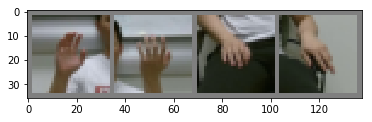

In [46]:
count = 0
for x, y in testloader:
        if count == 1:
            break
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = fixed_model_gpu(x_var)
        _, preds = scores.data.cpu().max(1)
        
        imshow(torchvision.utils.make_grid(x))
        print("preds: " , preds)
        #print("x: ", x)
        print("preds:", display_class(preds))
        print("actual: ", display_class(y))
        
        
        print()
        scores2 = fixed_model2_gpu(x_var)
        _, preds2 = scores2.data.cpu().max(1)
        
        print("preds2:", preds2)
        print("preds2:", display_class2(preds2))
       
        print()
        
        #num_correct += (preds == y).sum()
        #num_samples += preds.size(0)
        count += 1
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """



preds:  tensor([ 1,  1,  0,  1])
preds: ['right', 'right', 'left', 'right']

preds2: ['closed', 'open', 'open', 'open']
preds2: tensor([ 0,  1,  1,  1])
actual:  ['closed', 'open', 'open', 'open']


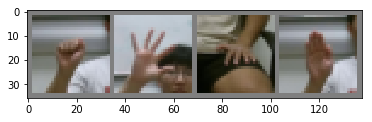

In [47]:
count = 0
for x, y in testloader2:
        if count == 1:
            break
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        
        scores = fixed_model_gpu(x_var)
        _, preds = scores.data.cpu().max(1)
        
        scores2 = fixed_model2_gpu(x_var)
        _, preds2 = scores2.data.cpu().max(1)
        
        print()
        print("preds: " , preds)
        print("preds:", display_class(preds))
        print()
        
        print("preds2:", display_class2(preds2))
        print("preds2:", preds2)
        print("actual: ", display_class2(y))
        
        
        imshow(torchvision.utils.make_grid(x))
     
        #num_correct += (preds == y).sum()
        #num_samples += preds.size(0)
        count += 1

In [49]:
torch.save(fixed_model_gpu.state_dict(),"left_right_model_gpu")
torch.save(fixed_model2_gpu.state_dict(),"open_closed_model_gpu")